# Import Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import praw
import os
import re
import nltk
import time
import random
import emoji

import string
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models
import warnings
warnings.filterwarnings("ignore")
from langdetect import detect_langs
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from string import punctuation
from collections import Counter, defaultdict
from wordcloud import WordCloud
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords 
nltk.download('stopwords')


/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/datascience/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Define Functions

In [3]:
# Some punctuation variations
punctuation = set(string.punctuation)
tw_punct = punctuation - {"#"}

# Stopwords
add_stopwords = ['comment', 'comment_score','commentscore','comment score']
sw = stopwords.words("english")
#sw.extend(new_stopwords)

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# Find the count of emojis within the dataframe
def contains_emoji(s):
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]
    return len(emojis) > 0

# Remove the stop words from the dataframe
def remove_stop(tokens) :
    stop_words = set(stopwords.words("english"))
    stop_words.update(add_stopwords)
    return [word for word in tokens if word.lower() not in stop_words]
 
# Remove the punctuation from the dataframe
def remove_punctuation(text, punct_set=tw_punct) : 
    return "".join([ch for ch in text if ch not in punct_set])

# Create the tokens by splitting on whitespace
def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    return re.split(whitespace_pattern, text)

# Define the lemmatizer function
def lemmatize(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

# Define the function for preparing the data for the pipeline
def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return tokens



## Data Import

### Open Source 

In [4]:
# Load the CSV file into a pandas DataFrame
df = pd.read_csv('/Users/datascience/Desktop/Cap/CA_business_reviews.csv')

## EDA

In [5]:
# Print the first five rows to get an idea of the data
print(df.head())

# Print the shape of the DataFrame (number of rows and columns)
print('Data shape:', df.shape)

# Print the column names
print('Column names:', df.columns)

# Print the data types of each column
print('Data types:', df.dtypes)

# Check for any missing values
print('Missing values:\n', df.isnull().sum())

# Generate summary statistics for numerical columns
print('Summary statistics:\n', df.describe())

# Check for any duplicated rows
print('Number of duplicated rows:', df.duplicated().sum())

# Print # of Unique for City
print("The Unique variables in City is:", df['city'].unique())

              business_id                      name                 address  \
0  Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ  1616 Chapala St, Ste 2   
1  Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ  1616 Chapala St, Ste 2   
2  Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ  1616 Chapala St, Ste 2   
3  Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ  1616 Chapala St, Ste 2   
4  Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ  1616 Chapala St, Ste 2   

            city state  postal_code   latitude   longitude  stars_x  \
0  Santa Barbara    CA      93101.0  34.426679 -119.711197      5.0   
1  Santa Barbara    CA      93101.0  34.426679 -119.711197      5.0   
2  Santa Barbara    CA      93101.0  34.426679 -119.711197      5.0   
3  Santa Barbara    CA      93101.0  34.426679 -119.711197      5.0   
4  Santa Barbara    CA      93101.0  34.426679 -119.711197      5.0   

   review_count  ...                                         categories hours  \
0             7  

### Filter Resturants/Food

In [6]:
# Drop rows with NaN values in categories column
df = df.dropna(subset=['categories'])

# Keep only rows where categories contain 'restaurants' or 'food'
df = df[df['categories'].str.contains('restaurants|food', case=False, regex=True)]

# Get the length of the resulting dataframe
length = len(df)

print(f"Length of dataset: {length}")

Length of dataset: 239065


### Clean Text Using Pipeline

In [7]:
# Apply the pipeline to the  dataframe
clean_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop, lemmatize]
df["tokens"] = df["text"].apply(prepare, pipeline=clean_pipeline)
df["num_tokens"] = df["tokens"].map(len) 
df['has_emoji'] = df["text"].apply(contains_emoji)
df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars_x,review_count,...,user_id,stars_y,useful,funny,cool,text,date,tokens,num_tokens,has_emoji
31,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,"131 Anacapa St, Ste C",Santa Barbara,CA,93101.0,34.414445,-119.690672,4.0,389,...,bFPdtzu11Oi0f92EAcjqmg,5,0,0,0,What a great addition to the Funk Zone! Grab ...,2016-10-13 22:50:47,"[great, addition, funk, zone, grab, bite, grab...",24,False
32,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,"131 Anacapa St, Ste C",Santa Barbara,CA,93101.0,34.414445,-119.690672,4.0,389,...,Ttb21DpWqphQMNSS5TXgMA,5,0,0,0,Possibly the best breakfast sandwich EVER. On...,2017-01-15 00:36:04,"[possibly, best, breakfast, sandwich, ever, bi...",9,False
33,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,"131 Anacapa St, Ste C",Santa Barbara,CA,93101.0,34.414445,-119.690672,4.0,389,...,ha2Lv7WnxvdYnRsqwL1apQ,4,0,0,0,Pricey ( a ham and cheese croissant was $5.50)...,2018-07-17 00:20:41,"[pricey, ham, cheese, croissant, 550, anywhere...",46,False
34,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,"131 Anacapa St, Ste C",Santa Barbara,CA,93101.0,34.414445,-119.690672,4.0,389,...,OVLf6NVTi7noMP1qCKr76w,5,0,1,1,Are you kidding me? This is without a doubt so...,2018-01-09 20:44:47,"[kidding, without, doubt, best, food, ive, eve...",30,False
35,IDtLPgUrqorrpqSLdfMhZQ,Helena Avenue Bakery,"131 Anacapa St, Ste C",Santa Barbara,CA,93101.0,34.414445,-119.690672,4.0,389,...,2ykh0_q0uMLFtypLDVSqlg,2,3,0,0,"Super slow service, ""salads"" are not very good...",2017-02-09 19:09:31,"[super, slow, service, salad, good, really, pr...",9,False


### Clean City Names 

In [8]:
# define a dictionary of correct spellings for misspelled cities
corrections = {
    'santa Barbara': 'Santa Barbara',
    'Santa Barbara ': 'Santa Barbara',
    'Real Goleta': 'Goleta',
    'Santa Barbara,': 'Santa Barbara',
    'SANTA BARBARA AP': 'Santa Barbara',
    'Santa Barbra': 'Santa Barbara',
    'SANTA BARBARA': 'Santa Barbara',
    'Santa  Barbara': 'Santa Barbara',
    'Carpinteria ': 'Carpinteria',
    'Santa Barbara & Ventura Counties':'Santa Barbara'
}

# apply the corrections and capitalize the first letter of each word
df['city'] = df['city'].replace(corrections).str.title()

# print the updated dataframe
print(df['city'].unique())

['Santa Barbara' 'Isla Vista' 'Goleta' 'Carpinteria' 'Montecito'
 'Port Hueneme' 'Summerland' 'Santa Clara' 'Truckee' 'Santa Maria']


### Delete Cities that are not near or in Santa Barbara

In [9]:
valid_cities = ['Santa Barbara', 'Isla Vista', 'Goleta', 'Carpinteria', 'Montecito', 'Summerland', 'Santa Ynez', 'Mission Canyon', 'Oxnard']

df = df[df['city'].isin(valid_cities)]

### Descriptive Statistics

In [10]:
#create the descriptive statistics function
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :

    total_types = []
    true_total = []
    num_tokens = 0
    num_unique_tokens = 0
    lexical_diversity = 0.0
    num_characters = 0

    #get unique list of tokens
    for token in tokens:
        #print(token)
        for i in token:
            true_total.append(i)
            num_tokens += 1
            if i in total_types:
                pass
            else:
                total_types.append(i)
                num_unique_tokens += 1
            for character in i:
                num_characters +=1
                
    lexical_diversity = round(num_unique_tokens / num_tokens , 3)
                
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")    

    #collect the 5 most common tokens
    counter_list = Counter(true_total)
    top_5 = counter_list.most_common(5)
    print(top_5)

    return([num_tokens, num_unique_tokens,lexical_diversity,num_characters])

In [11]:
#return the descriptive stats for the yelp data (tokens column)
descriptive_stats(df['tokens'])

<AxesSubplot:title={'center':'Average Comment Length by Resturant'}, xlabel='name'>

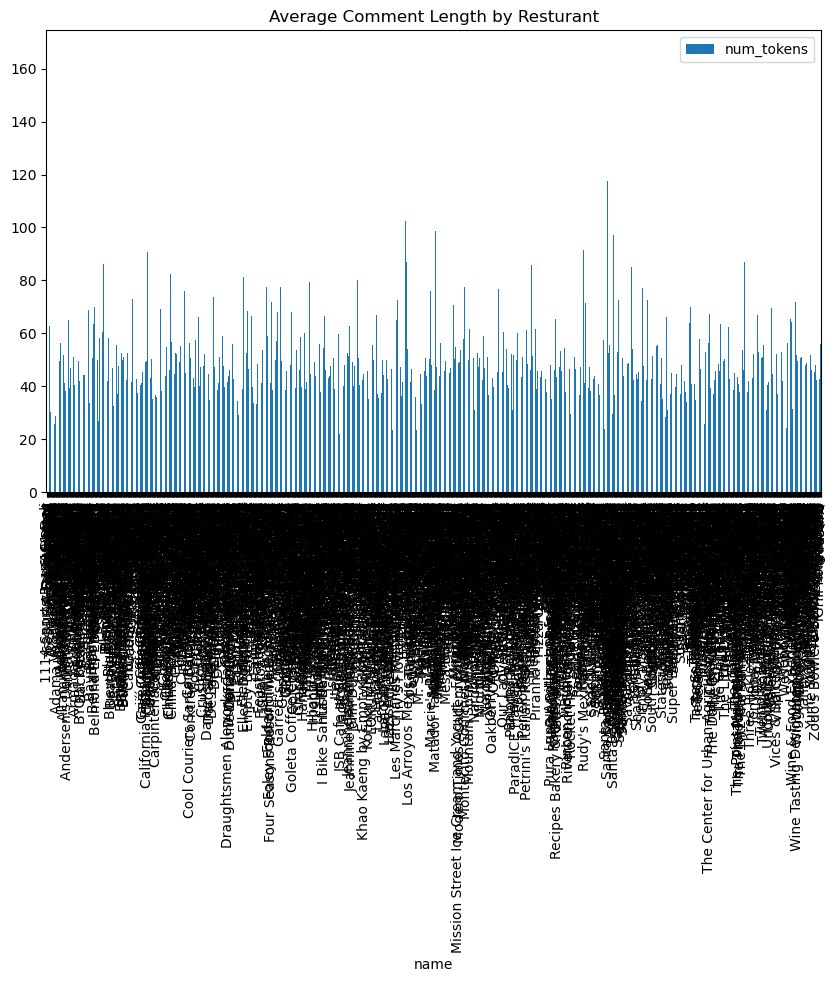

In [12]:
#view the mean wordcount by resturant
%matplotlib inline
df.groupby('name').agg({'num_tokens': 'mean'}).plot.bar(figsize=(10,6), title = "Average Comment Length by Resturant")

<AxesSubplot:title={'center':'Average Comment Length by Restaurant (Top 25)'}, xlabel='name'>

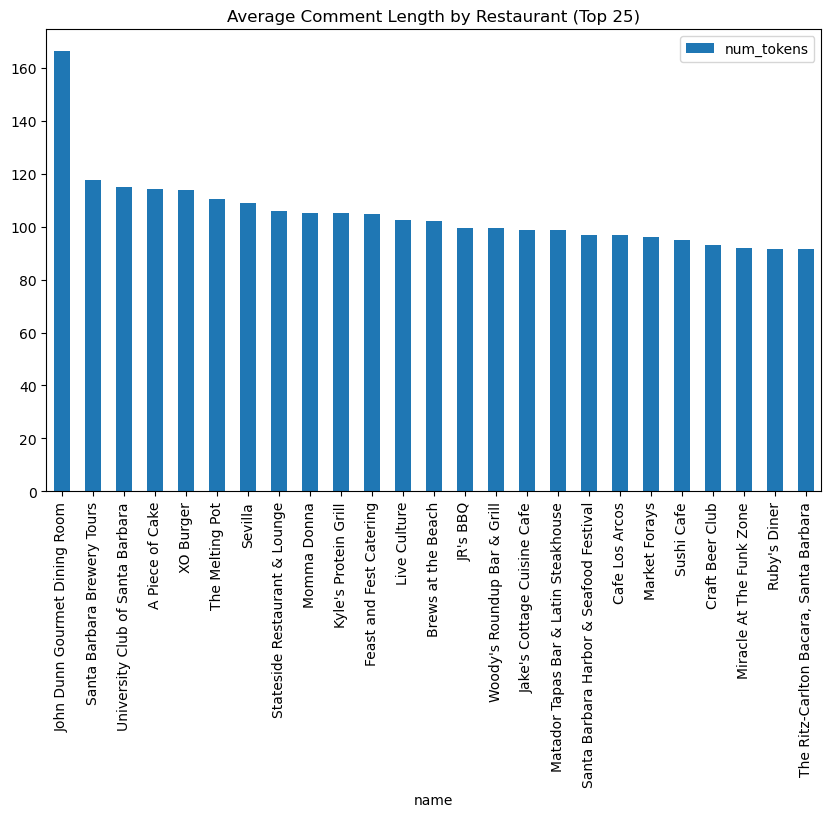

In [13]:
# Top 25
%matplotlib inline
df.groupby('name').agg({'num_tokens': 'mean'}).sort_values(by='num_tokens', ascending=False)[:25].plot.bar(figsize=(10,6), title = "Average Comment Length by Restaurant (Top 25)")

<AxesSubplot:title={'center':'Bottom 25 Average Comment Length by Restaurant'}, xlabel='name'>

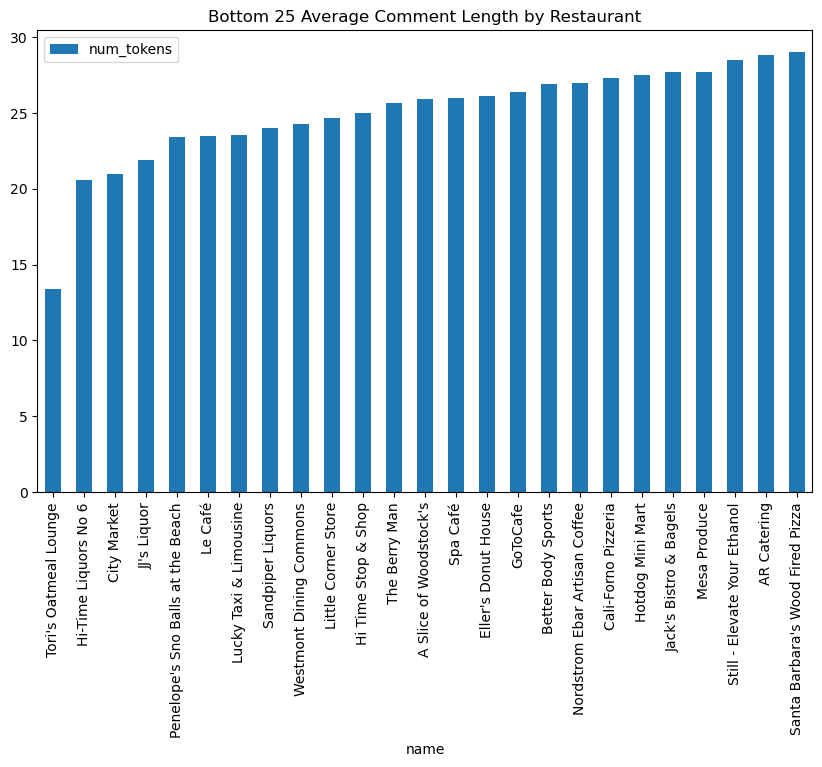

In [14]:
# Bottom 25
%matplotlib inline
df.groupby('name').agg({'num_tokens': 'mean'}).sort_values('num_tokens', ascending=True).head(25).plot.bar(figsize=(10,6), title="Bottom 25 Average Comment Length by Restaurant")

### Word Cloud

#### Combined Word Cloud

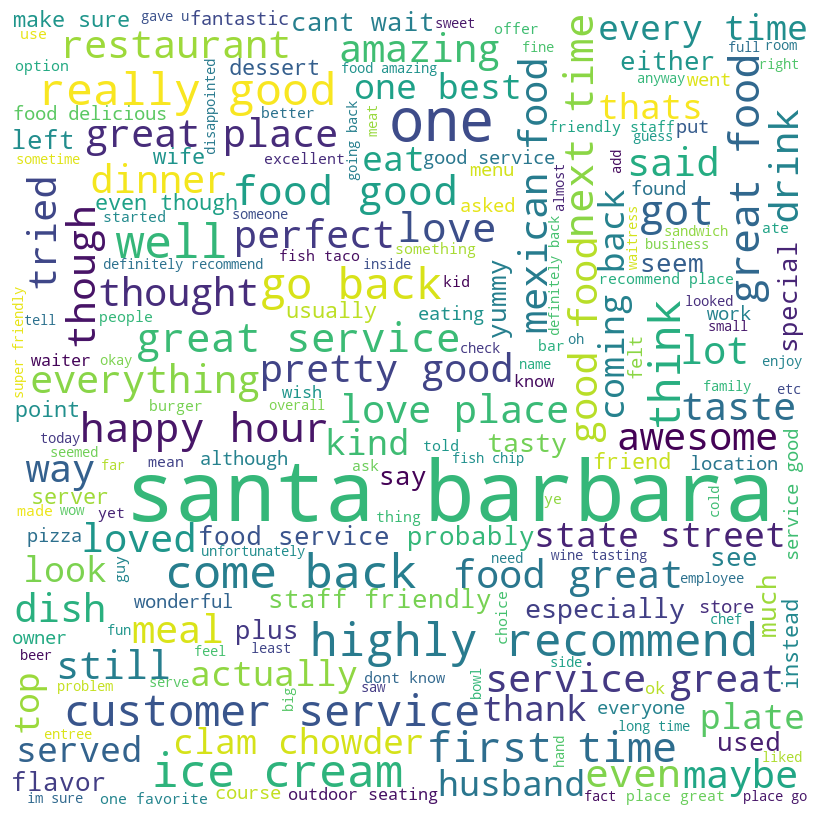

In [14]:
# Combine all reviews into a single list of tokens
tokens = [token for comment_tokens in df['tokens'] for token in comment_tokens]

# Create a word cloud object and generate the word cloud
text = ' '.join(tokens)
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)

# Display the generated image
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

#### Wordcloud based on Rating

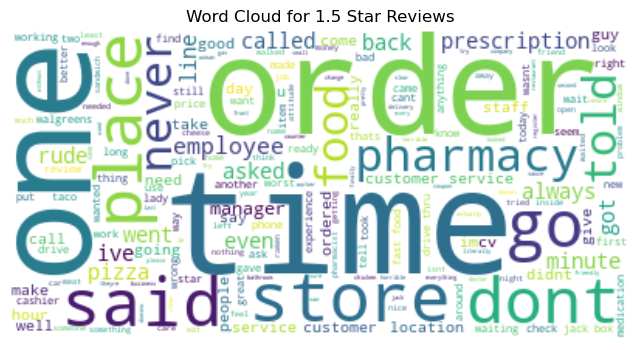

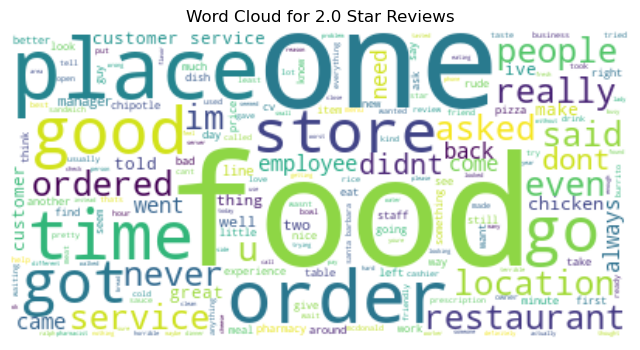

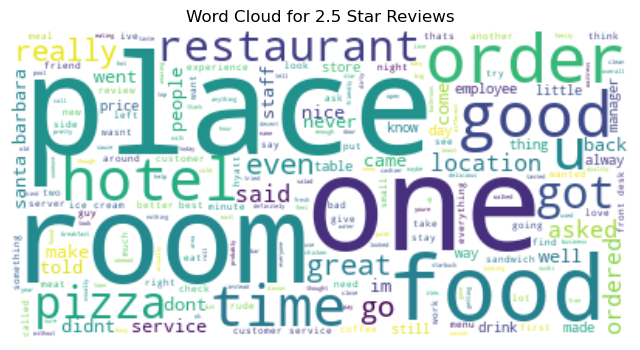

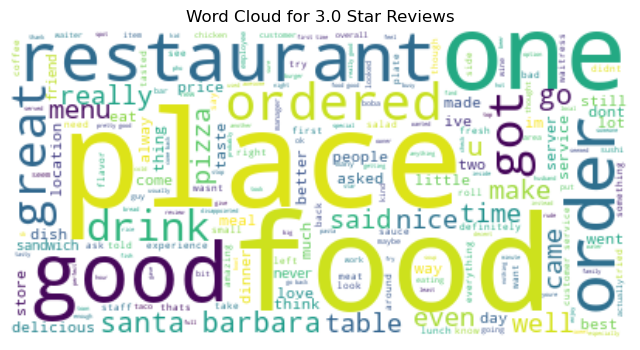

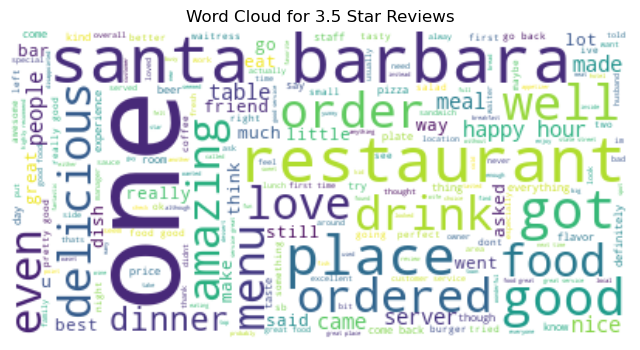

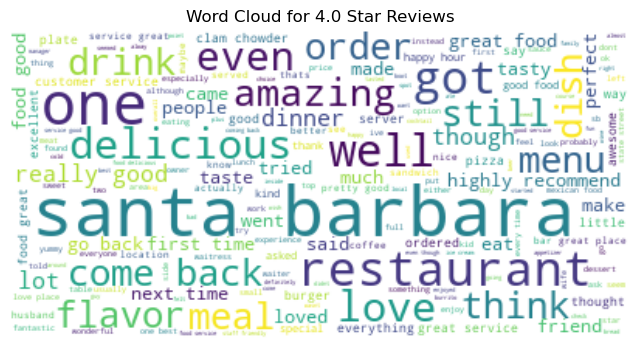

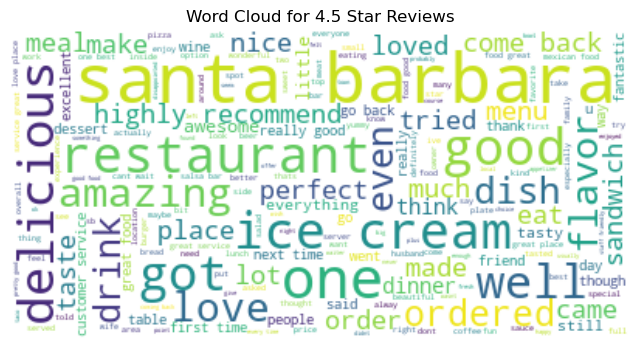

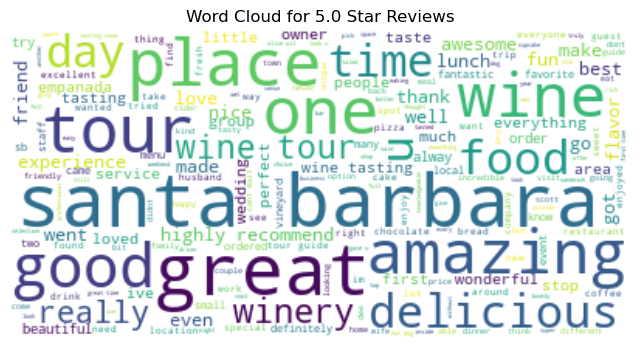

In [15]:
# create a list of unique rating scores
rating_scores = sorted(list(df['stars_x'].unique()))

# loop through each rating score
for rating_score in rating_scores:
    # filter the dataframe to only include reviews with the current rating score
    filtered_df = df[df['stars_x'] == rating_score]
    
    # create a list of all the words in the reviews
    words_list = [word for sublist in filtered_df['tokens'] for word in sublist]
    
    # join the words into a single string
    text = ' '.join(words_list)
    
    # create and generate a word cloud image
    wordcloud = WordCloud(background_color='white').generate(text)
    
    # plot the word cloud
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {rating_score} Star Reviews')
    plt.show()


### Distribution of Ratings

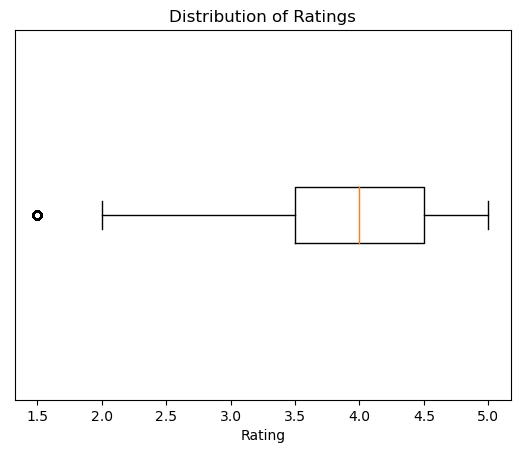

In [16]:
# Load the data
data = df

# Create boxplot
plt.boxplot(data['stars_x'], vert=False)

# Add title and labels
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.yticks([])

# Show the chart
plt.show()


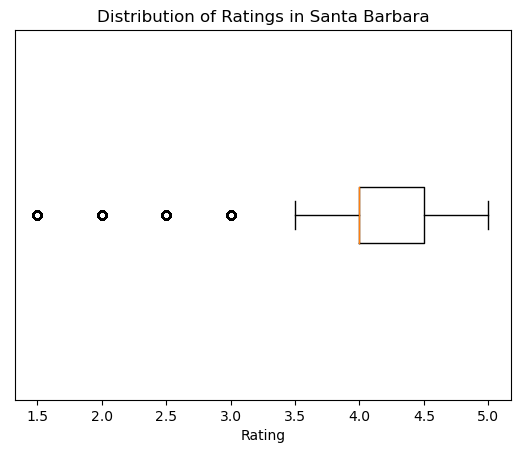

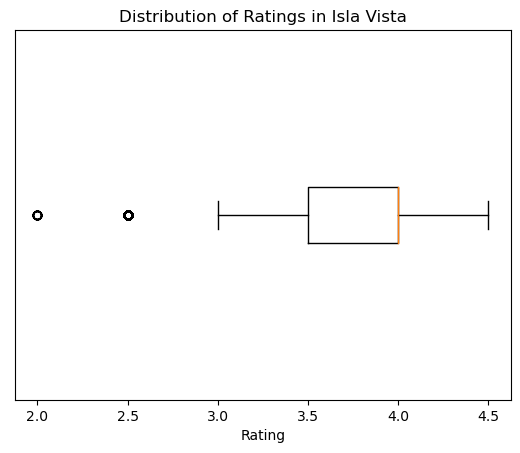

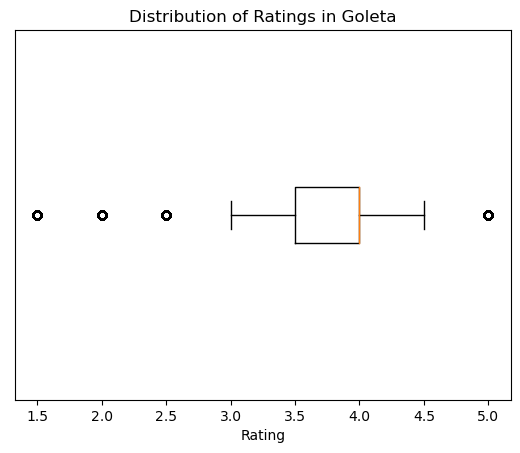

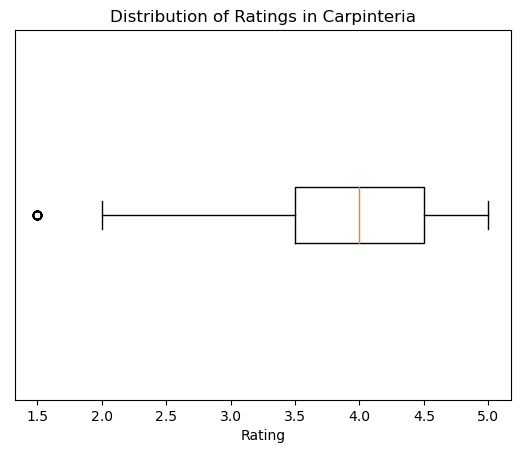

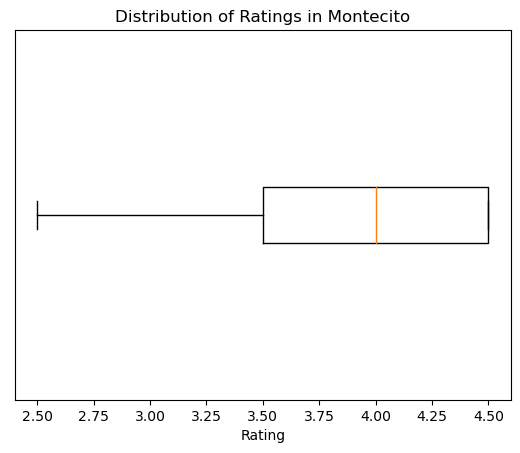

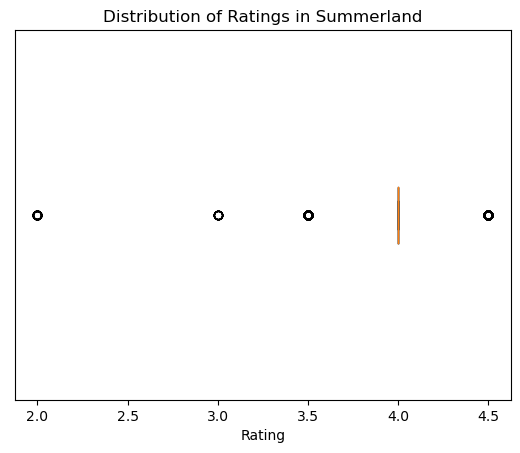

In [17]:
# Load the data
data = df

# Create boxplot for each city
cities = data['city'].unique()
for city in cities:
    plt.boxplot(data[data['city'] == city]['stars_x'], vert=False)
    plt.title(f"Distribution of Ratings in {city}")
    plt.xlabel("Rating")
    plt.yticks([])
    plt.show()


### Average Rating by City

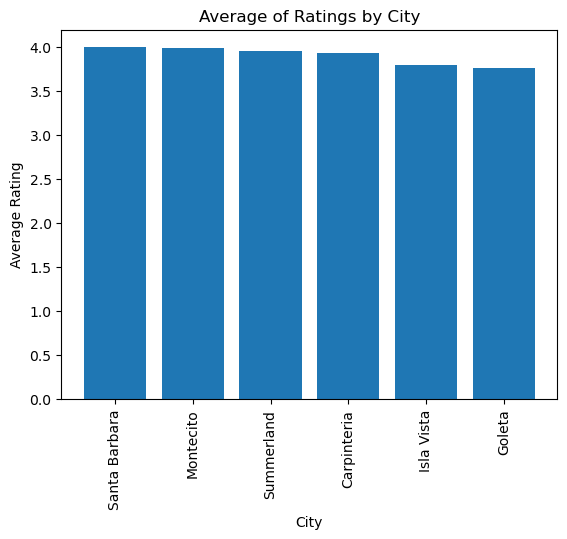

In [18]:
# Create a pivot table to aggregate ratings by city
city_ratings = pd.pivot_table(data, index='city', values='stars_x', aggfunc='mean')

# Sort the cities by average rating
city_ratings = city_ratings.sort_values('stars_x', ascending=False)

# Create a bar chart
plt.bar(city_ratings.index, city_ratings['stars_x'])

# Add title and labels
plt.title("Average of Ratings by City")
plt.xlabel("City")
plt.ylabel("Average Rating")

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Show the chart
plt.show()


### Average Rating by Resturant

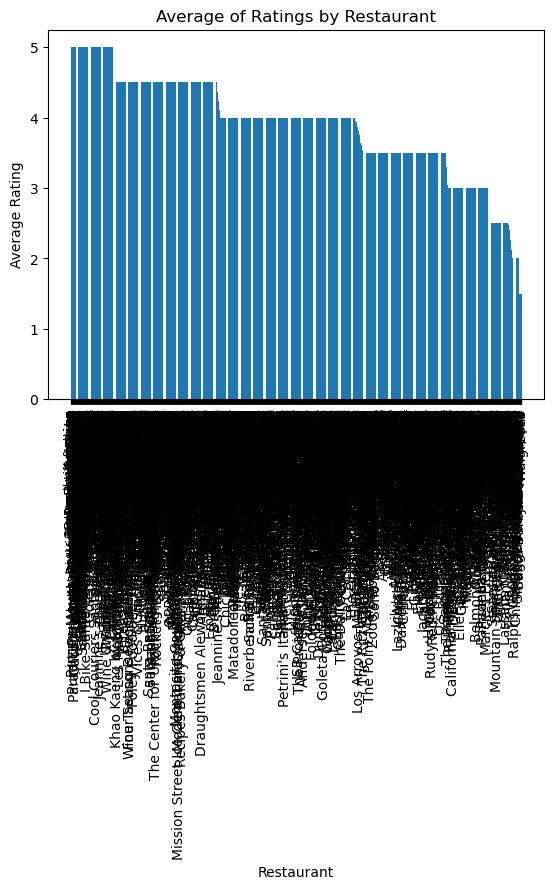

In [19]:
# Create a pivot table to aggregate ratings by restaurant
name_ratings = pd.pivot_table(data, index='name', values='stars_x', aggfunc='mean')

# Sort the restaurants by average rating
name_ratings = name_ratings.sort_values('stars_x', ascending=False)

# Create a bar chart
plt.bar(name_ratings.index, name_ratings['stars_x'])

# Add title and labels
plt.title("Average of Ratings by Restaurant")
plt.xlabel("Restaurant")
plt.ylabel("Average Rating")

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Show the chart
plt.show()


### Language Count

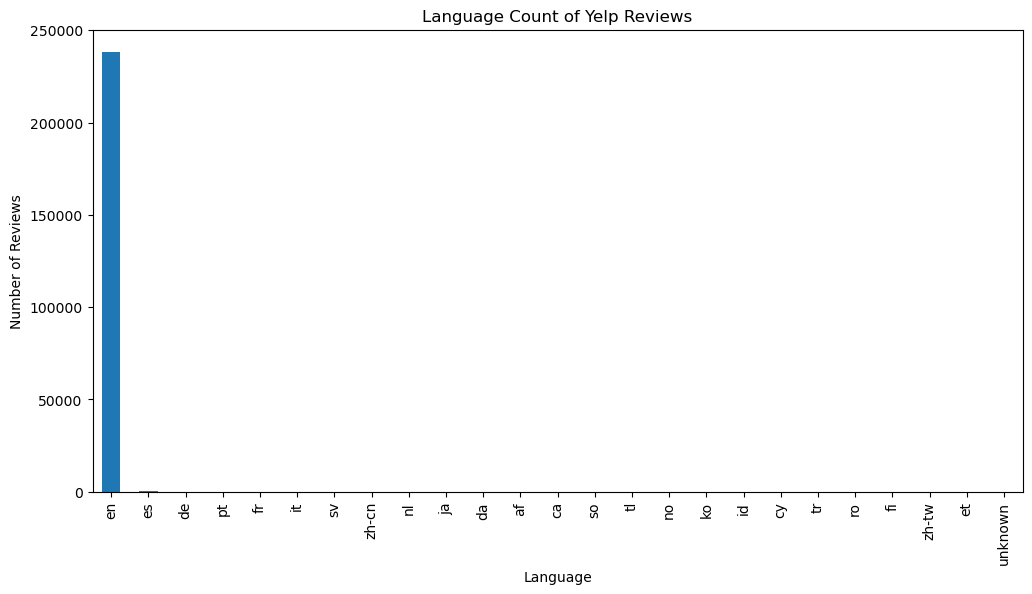

In [17]:
def detect_language(text):
    try:
        detected_langs = detect_langs(text)
        return detected_langs[0].lang
    except:
        return "unknown"

# Add a new column to the DataFrame with the detected language of the review text
df['language'] = df['text'].apply(detect_language)

# Calculate the language count
language_count = df['language'].value_counts()

# Plot the bar chart
plt.figure(figsize=(12, 6))
language_count.plot(kind='bar')
plt.title('Language Count of Yelp Reviews')
plt.xlabel('Language')
plt.ylabel('Number of Reviews')
plt.show()



In [19]:
lang_dict = {'en': 'English', 'es': 'Spanish', 'de': 'German', 'pt': 'Portuguese', 'fr': 'French', 'it': 'Italian', 'sv': 'Swedish', 'zh-cn': 'Chinese (Simplified)', 'nl': 'Dutch', 'ja': 'Japanese', 'da': 'Danish', 'af': 'Afrikaans', 'ca': 'Catalan', 'so': 'Somali', 'tl': 'Tagalog', 'no': 'Norwegian', 'ko': 'Korean', 'id': 'Indonesian', 'cy': 'Welsh', 'tr': 'Turkish', 'ro': 'Romanian', 'fi': 'Finnish', 'zh-tw': 'Chinese (Traditional)', 'et': 'Estonian', 'unknown': 'Unknown'}

df['language'] = df['language'].map(lang_dict)


In [20]:
df['language'].value_counts()

English                  238414
Spanish                     140
German                       83
Portuguese                   72
French                       61
Italian                      36
Swedish                      23
Chinese (Simplified)         22
Dutch                        20
Japanese                     19
Danish                       15
Afrikaans                    14
Catalan                       9
Somali                        6
Tagalog                       6
Norwegian                     6
Korean                        5
Indonesian                    4
Welsh                         4
Turkish                       2
Romanian                      2
Finnish                       2
Chinese (Traditional)         1
Estonian                      1
Unknown                       1
Name: language, dtype: int64

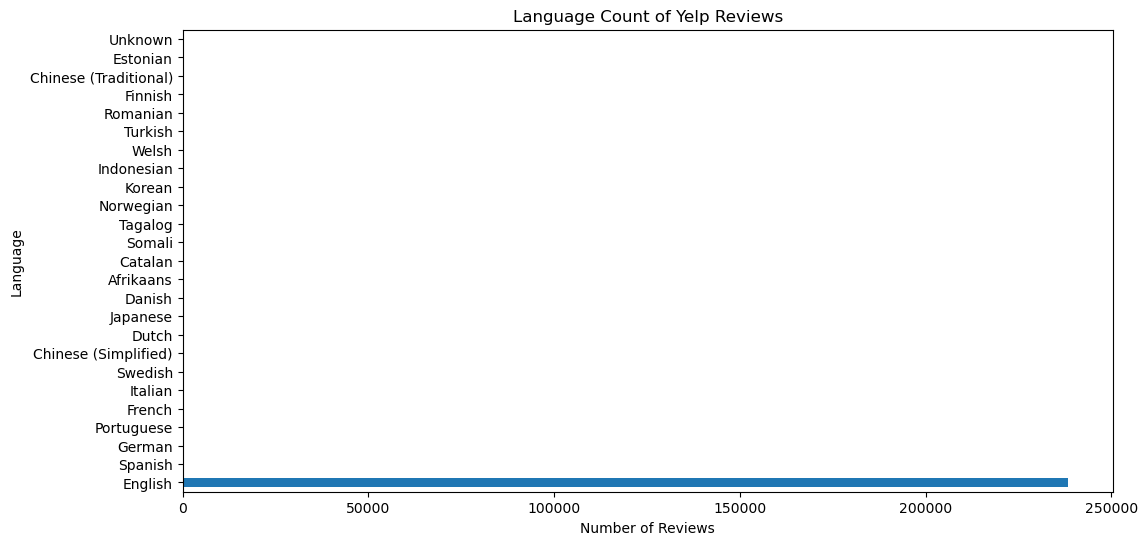

In [22]:
# Calculate the language count
language_count = df['language'].value_counts()

# Plot the horizontal bar chart
plt.figure(figsize=(12, 6))
language_count.plot(kind='barh')
plt.title('Language Count of Yelp Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Language')
plt.show()




In [23]:
# Calculate the review count for languages other than English and Spanish
other_count = df['language'].value_counts().sum() - df['language'].value_counts()[['English', 'Spanish']].sum()

# Calculate the total review count
total_count = df.shape[0]

# Calculate the percentage of data that is not English or Spanish
percent_other = (other_count / total_count) * 100

print('Percentage of data that is not English or Spanish: {:.2f}%'.format(percent_other))


Percentage of data that is not English or Spanish: 0.17%


In [ ]:
# Remove all languages except english and spanish
df = df[df['language'].isin(['en', 'es'])]

### Vote Columns Analysis (cool, useful, funny)

In [26]:
#Group by 'stars_x' and calculate the mean of 'useful', 'cool', 'funny', and 'num_tokens'
mean_values = df.groupby('stars_x')[['useful', 'cool', 'funny', 'num_tokens']].mean().round(3)

# Display the mean values table
print(mean_values)

         useful   cool  funny  num_tokens
stars_x                                  
1.5       1.092  0.233  0.504      49.138
2.0       1.236  0.442  0.606      53.970
2.5       1.050  0.381  0.455      54.152
3.0       0.929  0.427  0.396      49.495
3.5       0.954  0.471  0.387      51.495
4.0       0.960  0.585  0.401      48.534
4.5       0.977  0.656  0.400      46.021
5.0       1.508  1.138  0.587      49.988


In [27]:
# Calculate the correlation table
correlation_table = mean_values.corr().round(3)

# Display the correlation table
print(correlation_table)

            useful   cool  funny  num_tokens
useful       1.000  0.665  0.891       0.244
cool         0.665  1.000  0.303      -0.260
funny        0.891  0.303  1.000       0.435
num_tokens   0.244 -0.260  0.435       1.000


### Analysis on token length and stars

In [28]:
# Calculate the correlation between 'num_tokens' and 'stars_x'
correlation = df['num_tokens'].corr(df['stars_x']).round(3)

# Display the correlation
print("Correlation between 'num_tokens' and 'stars_x':", correlation)


Correlation between 'num_tokens' and 'stars_x': -0.04
